In [92]:
import numpy as np
from pl_bolts.datamodules import SklearnDataModule

from torch.utils.data import DataLoader, TensorDataset
import torch
from aeon.datasets import load_classification
import torch
from lightning import LightningModule, Trainer, seed_everything
from torch import nn
from torch.nn import functional as F

In [93]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from IPython.display import IFrame, JSON
from RuleTree import RuleTreeClassifier
from RuleTree.encoding.ruletree_to_jakowski_tree_encoder import ruletree_to_jakowski, jakowski_to_ruletree
from RuleTree.encoding.ruletree_to_jakowski_tree_encoder import deshift_jakowski_encoding

In [94]:
def print_np(arr, r=1):
    for i in range(arr.shape[0]):
        print('[', end='')
        for j in range(arr.shape[1]):
            print(f"{'' if i == 0 or arr[i-1, j]*arr[i,j]>=0 else ' '}{round(arr[i, j], r)},\t", end='')
        print(']')

## Generate Trees

In [95]:
MAX_DEPTH = 5

In [96]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

X_orig = iris_df.drop('target', axis=1).values
y = iris_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.3, random_state=0)

### First Tree

In [97]:
rt1 = RuleTreeClassifier(max_depth=MAX_DEPTH, prune_useless_leaves=True, random_state=0)
rt1.fit(X_train[::2], y_train[::2])
#rt.root.simplify()

print(classification_report(y_pred=rt1.predict(X_test), y_true=y_test))

y_pred_before_encoding_rt1 = rt1.predict(X_test)
y_pred_proba_before_encoding_rt1 = rt1.predict_proba(X_test)

rt1.export_graphviz(filename="demo")#, columns_names=iris_df.columns[:-1])
IFrame("demo.pdf", width=600, height=300)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.85      0.94      0.89        18
           2       0.89      0.73      0.80        11

    accuracy                           0.91        45
   macro avg       0.91      0.89      0.90        45
weighted avg       0.91      0.91      0.91        45



### Second Tree

In [98]:
rt2 = RuleTreeClassifier(max_depth=MAX_DEPTH, prune_useless_leaves=True, random_state=0)
rt2.fit(X_train[1::2], y_train[1::2])
#rt.root.simplify()

print(classification_report(y_pred=rt2.predict(X_test), y_true=y_test))

y_pred_before_encoding_rt2 = rt2.predict(X_test)
y_pred_proba_before_encoding_rt2 = rt2.predict_proba(X_test)

rt2.export_graphviz(filename="demo2")#, columns_names=iris_df.columns[:-1])
IFrame("demo2.pdf", width=600, height=300)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## Encode Trees

In [99]:
json = rt1.to_dict(filename="demo.json")
enc1 = ruletree_to_jakowski(json, depth=MAX_DEPTH)

json = rt2.to_dict(filename="demo2.json")
enc2 = ruletree_to_jakowski(json, depth=MAX_DEPTH)

/Users/francesco/github/RuleTree-dev/RuleTree/tree/RuleTree.py:637: UserWarning: As for now base_stump is not serializable
  warnings.warn("As for now base_stump is not serializable")


In [100]:
X = torch.Tensor(np.concatenate([enc1[None, ...], enc2[None, ...]], axis=0))
X.shape

torch.Size([2, 2, 63])

# Autoencoder

In [101]:
import lightning as L
import torch.nn.functional as F
from torch import nn

class TreeDataModule(L.LightningDataModule):
    def __init__(self, X_train, X_val, X_test, **dataloader_kwargs):
        super().__init__()

        self.X_train = TensorDataset(torch.Tensor(X_train))
        self.X_val = TensorDataset(torch.Tensor(X_val))
        self.X_test = TensorDataset(torch.Tensor(X_test))
        self.dataloader_kwargs = dataloader_kwargs

    def train_dataloader(self):
        return DataLoader(self.X_train, **self.dataloader_kwargs)

    def val_dataloader(self):
        return DataLoader(self.X_val, **self.dataloader_kwargs)

    def test_dataloader(self):
        return DataLoader(self.X_test, **self.dataloader_kwargs)

    def predict_dataloader(self):
        return DataLoader(self.X_test, **self.dataloader_kwargs)

In [102]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        in_channels = 2
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=8,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=8,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
        )

        self.fc = nn.Linear(32 * (self.n_nodes + 1) // 8, latent_dim)

    def forward(self, x):
        # input shape is (batch_size, 1, n_nodes)
        x = F.pad(x, (0, 1))  # add one fake node
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        in_channels = 2

        self.fc = nn.Linear(latent_dim, 32 * (self.n_nodes + 1) // 8)

        self.conv = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose1d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose1d(
                in_channels=8,
                out_channels=in_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 32, (self.n_nodes + 1) // 8)
        out = self.conv(out)
        out = out[:, :, :-1]
        return out

In [103]:
# see https://github.com/Lightning-Universe/lightning-bolts/blob/master/src/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py
class TreeVAE(LightningModule):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        kl_coeff: float = 0.1,
        latent_dim: int = 4,
        lr: float = 1e-4,
        **kwargs,
    ) -> None:
        super().__init__()

        self.save_hyperparameters()

        self.encoder = encoder
        self.decoder = decoder

        self.lr = lr
        self.kl_coeff = kl_coeff
        self.latent_dim = latent_dim

        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return self.decoder(z)

    def _run_step(self, x):
        x = self.encoder(x)
        # print(x.shape)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x = batch[0]
        # print(x.shape)
        z, x_hat, p, q = self._run_step(x)

        recon_loss = F.mse_loss(x_hat, x, reduction="mean")

        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }

        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [104]:
dataset = TreeDataModule(X_train=X, X_val=X, X_test=X, batch_size=2)
LATENT_DIM = 2

encoder = Encoder(
    latent_dim=LATENT_DIM, n_nodes=X.shape[2]
)
decoder = Decoder(
    latent_dim=LATENT_DIM, n_nodes=X.shape[2]
)
model = TreeVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=LATENT_DIM,
)

/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


In [ ]:
trainer = Trainer(max_epochs=1000)
trainer.fit(model, datamodule=dataset)

In [106]:
Z = model.encoder.forward(X).detach().numpy()
Z.shape

(2, 2)

In [107]:
import seaborn as sns
import pandas as pd

<Axes: xlabel='0', ylabel='1'>

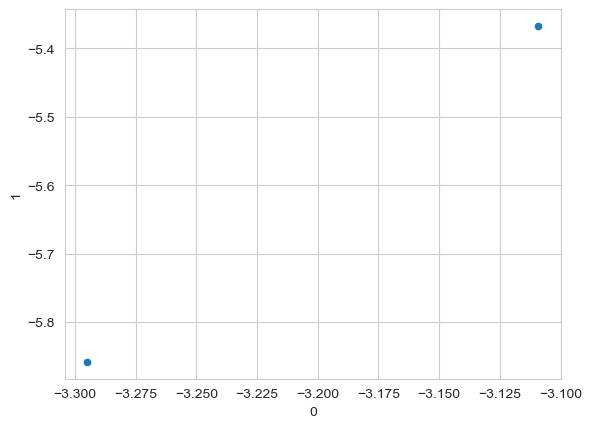

In [108]:
sns.scatterplot(data=pd.DataFrame(Z), x=0, y=1)

## Reconstruction

In [109]:
X_recon = model.forward(X).detach().numpy()
# manually replacing leaves with -1
X_recon[:, 0, X_recon.shape[-1] // 2:] = -1
X_recon.shape

(2, 2, 63)

In [110]:
enc1_recon = X_recon[0]
enc2_recon = X_recon[1]
enc1_recon.shape, enc2_recon.shape

((2, 63), (2, 63))

In [111]:
enc1_recon

array([[ 1.5028224 ,  3.322496  ,  2.8475199 ,  3.0702953 ,  3.7744427 ,
         3.3189712 ,  2.9713306 ,  2.6303697 ,  2.9799795 ,  2.7755923 ,
         3.0834665 ,  2.4442248 ,  2.8948002 ,  2.7932215 ,  3.316845  ,
         2.5971155 ,  2.9015822 ,  3.31106   ,  3.780949  ,  2.3350377 ,
         2.957955  ,  2.986608  ,  3.5130777 ,  2.408762  ,  2.7102618 ,
         2.9355893 ,  2.8938293 ,  2.5617056 ,  2.9321423 ,  3.2485685 ,
         2.4816504 , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [ 1.3787999 ,  1.1619275 ,  3.198847  ,  0.88866013,  2.5155013 ,
   

In [112]:
rt1_recon = jakowski_to_ruletree(enc1_recon)
rt2_recon = jakowski_to_ruletree(enc2_recon)

rt1_recon = RuleTreeClassifier.from_dict(rt1_recon)
rt2_recon = RuleTreeClassifier.from_dict(rt2_recon)

RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifier
RuleTree.stumps.classification.DecisionTreeStumpClassifi

In [120]:
rt1_recon.export_graphviz(filename="demo_recon")#, columns_names=iris_df.columns[:-1])
IFrame("demo_recon.pdf", width=600, height=300)

In [114]:
# import matplotlib.pyplot as plt
# i = 2
# plt.plot(X[i, 0].numpy())
# plt.plot(model.forward(X[i:i+1]).detach().numpy().ravel())